## 0. Importing required Libraries and modules

In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
from tqdm import tqdm
import os
import requests
import requests
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setting pandas to display all columns
pd.set_option('display.max_columns', None)

## 1. Datset Loading and Initial Statistical Analysis

In [5]:
# Load dataset
df = pd.read_csv("LB animal-shelter-intakes-and-outcomes.csv")

# Display basic info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30207 entries, 0 to 30206
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Animal ID          30207 non-null  object 
 1   Animal Name        17904 non-null  object 
 2   Animal Type        30207 non-null  object 
 3   Primary Color      30207 non-null  object 
 4   Secondary Color    14481 non-null  object 
 5   Sex                30207 non-null  object 
 6   DOB                26441 non-null  object 
 7   Intake Date        30207 non-null  object 
 8   Intake Condition   30207 non-null  object 
 9   Intake Type        30207 non-null  object 
 10  Intake Subtype     29768 non-null  object 
 11  Reason for Intake  2055 non-null   object 
 12  Outcome Date       30059 non-null  object 
 13  Crossing           30207 non-null  object 
 14  Jurisdiction       30206 non-null  object 
 15  Outcome Type       30051 non-null  object 
 16  Outcome 

In [6]:
# Check for missing values and their percentage
missing_values = df.isnull().sum()
missing_percentage = round((df.isnull().sum() / len(df)) * 100,2)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})

# Display the result
print("\nMissing Values Summary:")
print(missing_df)


Missing Values Summary:
                   Missing Values  Percentage (%)
Animal ID                       0            0.00
Animal Name                 12303           40.73
Animal Type                     0            0.00
Primary Color                   0            0.00
Secondary Color             15726           52.06
Sex                             0            0.00
DOB                          3766           12.47
Intake Date                     0            0.00
Intake Condition                0            0.00
Intake Type                     0            0.00
Intake Subtype                439            1.45
Reason for Intake           28152           93.20
Outcome Date                  148            0.49
Crossing                        0            0.00
Jurisdiction                    1            0.00
Outcome Type                  156            0.52
Outcome Subtype              3522           11.66
latitude                        0            0.00
longitude                

In [7]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


Summary Statistics:
       Animal ID Animal Name Animal Type Primary Color Secondary Color    Sex  \
count      30207       17904       30207         30207           14481  30207   
unique     29205        9227          10            82              44      5   
top      A637086           *         CAT         BLACK           WHITE   Male   
freq           8         125       14165          7621            8460   6829   
mean         NaN         NaN         NaN           NaN             NaN    NaN   
std          NaN         NaN         NaN           NaN             NaN    NaN   
min          NaN         NaN         NaN           NaN             NaN    NaN   
25%          NaN         NaN         NaN           NaN             NaN    NaN   
50%          NaN         NaN         NaN           NaN             NaN    NaN   
75%          NaN         NaN         NaN           NaN             NaN    NaN   
max          NaN         NaN         NaN           NaN             NaN    NaN   

      

In [8]:
# Create an empty list to store summary rows
summary_stats = []

# Iterate through each column to calculate the required statistics
for col in df.columns:
    non_null_count = df[col].notnull().sum()
    null_count = df[col].isnull().sum()
    percentage_nulls = round((null_count / len(df)) * 100, 2)
    unique_values = df[col].nunique()
    
    # Get the most frequent value and its frequency
    if non_null_count > 0:
        most_frequent_value = df[col].mode()[0]  # Get the most common value
        frequency_top_value = df[col].value_counts().iloc[0]  # Get count of the top mode
    else:
        most_frequent_value = None
        frequency_top_value = None

    summary_stats.append([
        col, non_null_count, null_count, percentage_nulls, 
        unique_values, most_frequent_value, frequency_top_value
    ])

# Convert list to DataFrame
summary_stats_df = pd.DataFrame(summary_stats, columns=[
    "Column Name", "Non-Null Count", "Null Count", "Percentage Nulls", 
    "Unique Values", "Most Frequent Value", "Frequency of Top Value"
])

# Save as CSV
summary_stats_df.to_csv("statistical_summary.csv", index=False)


Statistical Summary for Sex:
        Sex  Count  Percentage
0      Male   6829   22.607343
1   Unknown   6581   21.786341
2    Female   6176   20.445592
3  Neutered   5662   18.744000
4    Spayed   4959   16.416725


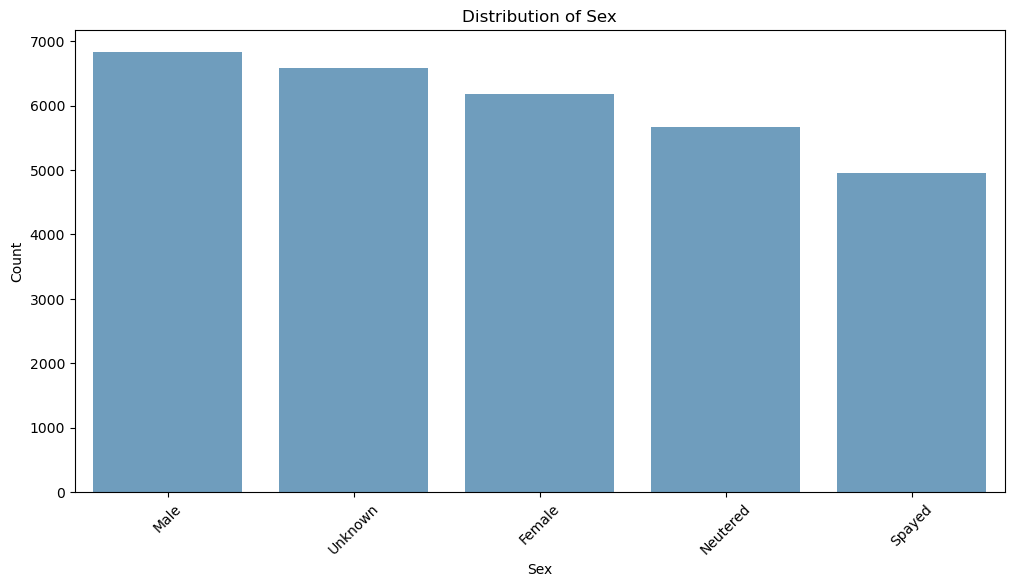


Statistical Summary for Intake Type:
              Intake Type  Count  Percentage
0                   STRAY  21136   69.970537
1                WILDLIFE   4677   15.483166
2         OWNER SURRENDER   2725    9.021088
3          WELFARE SEIZED    468    1.549310
4              CONFISCATE    460    1.522826
5                  RETURN    333    1.102393
6              QUARANTINE    167    0.552852
7               SAFE KEEP    132    0.436985
8    TRAP, NEUTER, RETURN     98    0.324428
9     Euthenasia Required      7    0.023173
10                 FOSTER      2    0.006621
11  Adopted Animal Return      2    0.006621


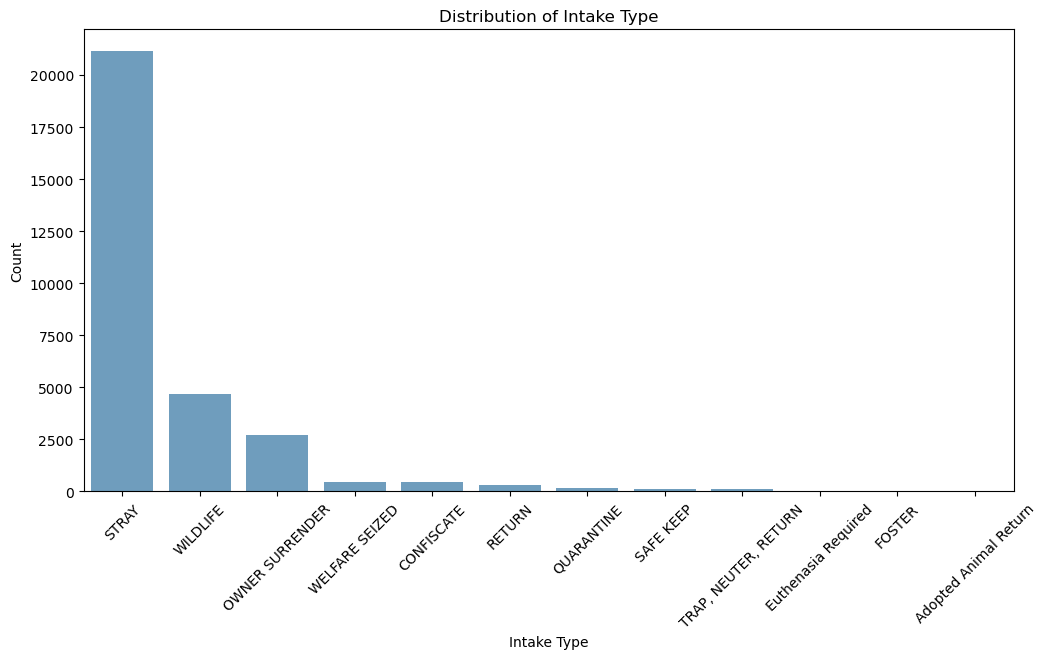


Statistical Summary for Outcome Type:
               Outcome Type  Count  Percentage
0                    RESCUE   6901   22.964294
1                  ADOPTION   6467   21.520083
2                EUTHANASIA   5362   17.843000
3                  TRANSFER   4949   16.468670
4           RETURN TO OWNER   3189   10.611960
5   SHELTER, NEUTER, RETURN    884    2.941666
6                      DIED    724    2.409238
7             COMMUNITY CAT    402    1.337726
8    RETURN TO WILD HABITAT    329    1.094805
9           FOSTER TO ADOPT    248    0.825264
10                TRANSPORT    198    0.658880
11                HOMEFIRST     86    0.286180
12                  MISSING     81    0.269542
13    TRAP, NEUTER, RELEASE     76    0.252903
14                 DISPOSAL     69    0.229610
15         RETURN TO RESCUE     47    0.156401
16                DUPLICATE     31    0.103158
17                   FOSTER      8    0.026621


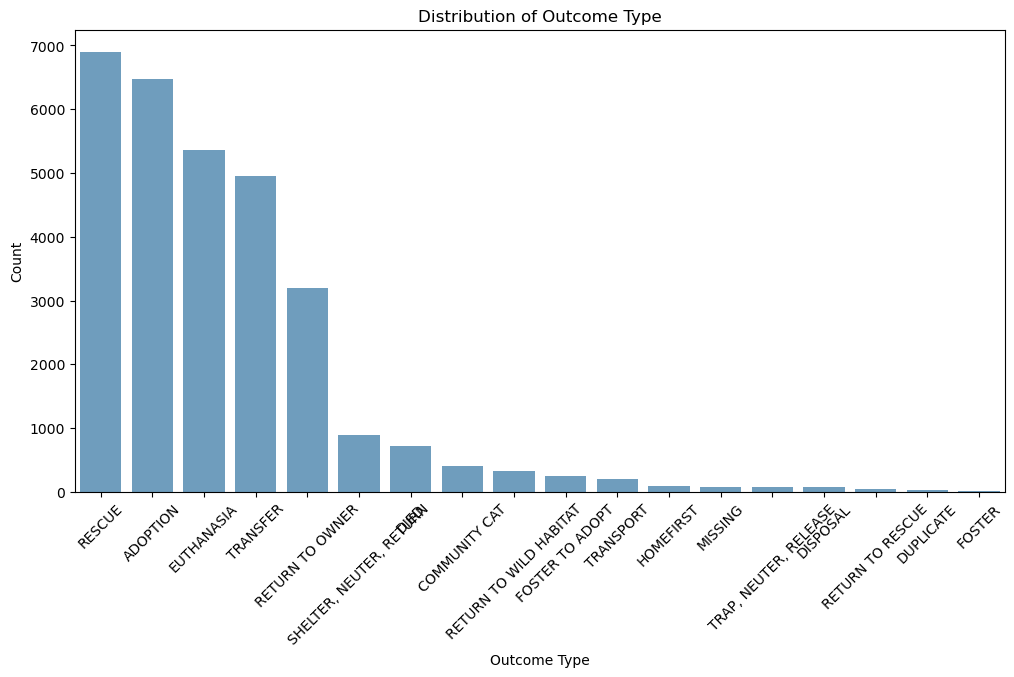


Statistical Summary for Animal Type:
  Animal Type  Count  Percentage
0         CAT  14165   46.893104
1         DOG   9847   32.598404
2        BIRD   2132    7.057967
3        WILD   1505    4.982289
4       OTHER   1432    4.740623
5      RABBIT    606    2.006158
6     REPTILE    330    1.092462
7  GUINEA PIG    178    0.589267
8   LIVESTOCK     10    0.033105
9   AMPHIBIAN      2    0.006621


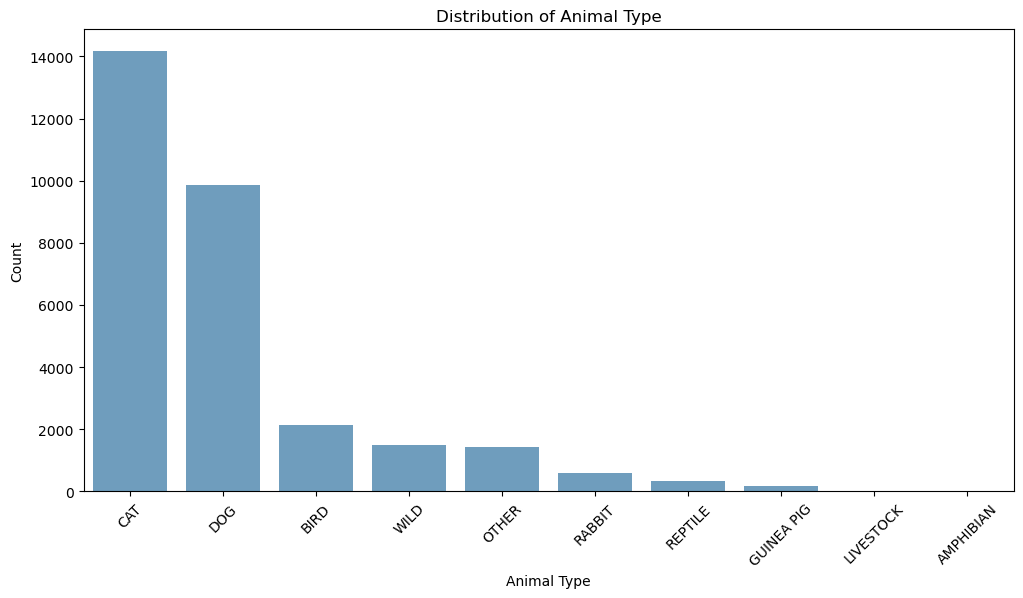

In [9]:
# Generating statistical summaries for some important variables
categorical_vars = ["Sex", "Intake Type", "Outcome Type", "Animal Type"]

# Create a summary table and visualize the distribution
for var in categorical_vars:
    # Compute count and percentage
    count_data = df[var].value_counts().reset_index()
    count_data.columns = [var, 'Count']
    count_data['Percentage'] = (count_data['Count'] / count_data['Count'].sum()) * 100

    # Display summary
    print(f"\nStatistical Summary for {var}:")
    print(count_data)

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(data=count_data, x=var, y="Count", legend=False, alpha=0.7)  # Assign hue to fix the warning
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {var}")
    plt.ylabel("Count")
    plt.xlabel(var)
    plt.show()

## 2. Data Preprocessing

In [11]:
# First remove any duplicates if animal ID, intake and outcome dates are exactly the same
df = df.drop_duplicates(subset=['Animal ID', 'Intake Date', 'Outcome Date'], keep='first')

### 2.1 Handling Sex Column

In [13]:
# Create new columns for true sex and surgical procedure
def extract_sex_info(sex):
    if 'Female' in sex or 'Spayed' in sex:
        True_sex = 'Female'
    elif 'Male' in sex or 'Neutered' in sex:
        True_sex = 'Male'
    else:
        True_sex = 'Unknown'
        
    if 'Neutered' in sex:
        Surgical_procedure = 'Neutered'
    elif 'Spayed' in sex:
        Surgical_procedure = 'Spayed'
    elif 'Unknown' in sex:
        Surgical_procedure = 'Unknown'
    else:
        Surgical_procedure = 'None'

    return pd.Series([True_sex, Surgical_procedure])

df[['true_sex', 'surgical_procedure']] = df['Sex'].apply(extract_sex_info)
df.head()

,Animal ID,Animal Name,Animal Type,Primary Color,Secondary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,Intake Subtype,Reason for Intake,Outcome Date,Crossing,Jurisdiction,Outcome Type,Outcome Subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,true_sex,surgical_procedure
0,A708149,NaN,REPTILE,BROWN,GREEN,Unknown,NaN,10/3/2023,NORMAL,STRAY,FIELD,NaN,10/3/2023,"`600 BLK E HARCOURT, LB 90805",LONG BEACH,RESCUE,OTHER RESC,33.867999,-118.200931,Alive on Intake,False,1,"33.8679994, -118.2009307",Unknown,Unknown
1,A638068,NaN,BIRD,GREEN,RED,Unknown,NaN,1/1/2020,INJURED SEVERE,WILDLIFE,FIELD,NaN,1/1/2020,"0 BLK GRAND AVE, LONG BEACH, CA 90803",LONG BEACH,EUTHANASIA,INJ SEVERE,33.760478,-118.148091,Alive on Intake,True,0,"33.7604783, -118.1480912",Unknown,Unknown
2,A639310,NaN,BIRD,WHITE,GRAY,Unknown,NaN,2/2/2020,ILL SEVERE,WILDLIFE,FIELD,NaN,2/2/2020,"0 BLK TEMPLE AVE, LONG BEACH, CA 90803",LONG BEACH,TRANSFER,LBAH,33.762460,-118.159678,Alive on Intake,False,1,"33.7624598, -118.1596777",Unknown,Unknown
3,A621052,*GREAT DANE,CAT,GRAY,NaN,Neutered,1/30/2016,1/30/2019,FRACTIOUS,STRAY,FIELD,NaN,2/6/2019,"0 W HOME ST, LONG BEACH, CA 90805",LONG BEACH,ADOPTION,SPCALA,33.847978,-118.195780,Alive on Intake,False,1,"33.8479781, -118.1957802",Male,Neutered
4,A619226,NaN,DOG,BROWN,BLACK,Male,12/24/2017,12/24/2018,INJURED MILD,STRAY,FIELD,NaN,12/30/2018,"00 BLK 68TH WAY, LONG BEACH, CA 90805",LONG BEACH,TRANSFER,SPCALA,33.878496,-118.203950,Alive on Intake,False,1,"33.8784962, -118.2039496",Male,None


### 2.2 Handling Date Columns
Also, creating 3 new numerical features: Age at Intake, Age at Outcome and Shelter Days (No. of Days spent in the shelter)

In [15]:
# First, from initial exploration, we know that the Intake date does not have any nulls, while the Outcome date does (A very small percentage ~0.5%)
# We are going to assume that these animals are still at the shelter. 
# In support of these assumptions, we verified from the dataset that all animals with missing outcome dates had intakes in recent years (2023-2025)
# For the calculation of the ages and shelter days, we will last_date (extract date: 8 Feb) as the date to calculate age and shelter days.

# Creating a variable for the first and last dates
first_date = pd.Timestamp("2017-01-01")
last_date = pd.Timestamp("2025-02-08")

In [16]:
# Convert date columns to date-time format
df['Intake Date'] = pd.to_datetime(df['Intake Date'], errors='coerce')
df['Outcome Date'] = pd.to_datetime(df['Outcome Date'], errors='coerce')
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')

In [17]:
# Checking if there are any dates in past or future

df[(df['Intake Date'] > last_date) | (df['Intake Date'] < first_date) |
(df['Outcome Date'] > last_date) | (df['Outcome Date'] < first_date) |
(df['DOB'] > last_date)] # DOB can be in past


,Animal ID,Animal Name,Animal Type,Primary Color,Secondary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,Intake Subtype,Reason for Intake,Outcome Date,Crossing,Jurisdiction,Outcome Type,Outcome Subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,true_sex,surgical_procedure
22171,A656513,*,CAT,BLACK,WHITE,Male,2031-03-30,2021-04-21,UNDER AGE/WEIGHT,STRAY,OTC,NaN,2021-04-21,"7700 E SPRING ST, LONG BEACH, CA 90815",LONG BEACH,RESCUE,HOUSEOBC,33.809612,-118.082616,Alive on Intake,False,1,"33.8096122, -118.0826161",Male,None


In [18]:
# Above row is clearly entered in error. DOB cannot be in 2031! 
# From intake condition (UNDERAGE/WEGHT), we can safely assume that the actual DOB is going to be close to the Intake date (2021-04-21).
# As a spot fix, we can modify this row to DOB of 2021-03-30
df.loc[df['Animal ID'] == 'A656513', 'DOB'] = pd.Timestamp('2021-03-30')

# Verifying the fix
df[df['Animal ID'] == 'A656513']

,Animal ID,Animal Name,Animal Type,Primary Color,Secondary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,Intake Subtype,Reason for Intake,Outcome Date,Crossing,Jurisdiction,Outcome Type,Outcome Subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,true_sex,surgical_procedure
22171,A656513,*,CAT,BLACK,WHITE,Male,2021-03-30,2021-04-21,UNDER AGE/WEIGHT,STRAY,OTC,NaN,2021-04-21,"7700 E SPRING ST, LONG BEACH, CA 90815",LONG BEACH,RESCUE,HOUSEOBC,33.809612,-118.082616,Alive on Intake,False,1,"33.8096122, -118.0826161",Male,None


In [19]:
# Calculate age at intake and outcome
df['age_at_intake'] = (df['Intake Date'] - df['DOB']).dt.days
df['age_at_outcome'] = (df['Outcome Date'] - df['DOB']).dt.days
# Fill missing Age at Outcome values using extract_date - DOB (for animals still in the shelter)
df.loc[df["age_at_outcome"].isna(), "age_at_outcome"] = (last_date - df["DOB"]).dt.days

# Calculate Shelter Duration
df["Shelter Duration"] = (df["Outcome Date"] - df["Intake Date"]).dt.days

# Fill missing Shelter Duration values (for animals still in the shelter)
df.loc[df["Shelter Duration"].isna(), "Shelter Duration"] = (last_date - df["Intake Date"]).dt.days


In [20]:
# Verify if either age at intake is negative
df.loc[(df['age_at_intake'] <= 0), ['DOB','Intake Date', 'age_at_intake', 'Intake Condition', 'Intake Type','Intake Subtype', 'Reason for Intake']]


,DOB,Intake Date,age_at_intake,Intake Condition,Intake Type,Intake Subtype,Reason for Intake
96,2023-12-26,2023-12-26,0.0,NORMAL,STRAY,OTC,NaN
216,2021-08-03,2021-08-03,0.0,UNDER AGE/WEIGHT,STRAY,OTC,NaN
218,2021-08-03,2021-08-03,0.0,UNDER AGE/WEIGHT,STRAY,OTC,NaN
254,2023-04-20,2023-04-19,-1.0,UNDER AGE/WEIGHT,STRAY,BORN@SHELT,NaN
255,2023-04-20,2023-04-19,-1.0,UNDER AGE/WEIGHT,STRAY,BORN@SHELT,NaN
...,...,...,...,...,...,...,...
29706,2023-05-29,2023-05-29,0.0,UNDER AGE/WEIGHT,WILDLIFE,FIELD,NaN
29708,2023-05-29,2023-05-29,0.0,UNDER AGE/WEIGHT,WILDLIFE,FIELD,NaN
29825,2024-09-14,2024-09-14,0.0,UNDER AGE/WEIGHT,STRAY,FIELD,NaN
29913,2017-07-03,2017-07-03,0.0,UNDER AGE/WEIGHT,OWNER SURRENDER,FIELD,NaN


In [21]:
# Select rows with negative intake age
incorrect_intake_age_rows = df.loc[(df['age_at_intake'] < 0), ['DOB','Intake Date', 'age_at_intake', 'Intake Condition', 'Intake Type','Intake Subtype', 'Reason for Intake']]

# Get unique values for problematic intake records
unique_intake_values_counts = {
    'Intake Condition': incorrect_intake_age_rows['Intake Condition'].value_counts().to_dict(),
    'Intake Type': incorrect_intake_age_rows['Intake Type'].value_counts().to_dict(),
    'Intake Subtype': incorrect_intake_age_rows['Intake Subtype'].value_counts().to_dict(),
    'Reason for Intake': incorrect_intake_age_rows['Reason for Intake'].value_counts().to_dict() }
    
print('Unique Intake Conditions: ', unique_intake_values_counts['Intake Condition'])
print('Unique Intake Types: ', unique_intake_values_counts['Intake Type'])
print('Unique Intake Subtypes: ', unique_intake_values_counts['Intake Subtype'])
print('Unique Intake Reasons: ', unique_intake_values_counts['Reason for Intake'])


Unique Intake Conditions:  {'UNDER AGE/WEIGHT': 93, 'NORMAL': 28, 'BEHAVIOR  MODERATE': 6, 'FERAL': 4, 'ILL MODERATETE': 2}
Unique Intake Types:  {'STRAY': 113, 'OWNER SURRENDER': 18, 'WELFARE SEIZED': 2}
Unique Intake Subtypes:  {'OTC': 63, 'FIELD': 43, 'BORN@SHELT': 10, 'TRAP': 8, 'AT SHELTER': 6, 'POLICE': 2, 'ABAN FIELD': 1}
Unique Intake Reasons:  {'TOO MANY': 3, 'OTHER PET': 1}


In [22]:
# Swap DOB and intake_date when age_at_intake is negative
negative_age_mask = df['age_at_intake'] < 0
df.loc[negative_age_mask, ['DOB', 'Intake Date']] = df.loc[negative_age_mask, ['Intake Date', 'DOB']].values

# Recalculate age at intake after swap
df['age_at_intake'] = (df['Intake Date'] - df['DOB']).dt.days

In [23]:
# Similarly, verifying if the age at the outcome is 0 or negative
incorrect_outcome_age_rows = df.loc[(df['age_at_outcome'] < 0), ['DOB','Outcome Date','age_at_outcome', 'Outcome Type','Outcome Subtype','outcome_is_dead']]

# Get unique values for problematic intake records
unique_outcome_values_counts = {
    'Outcome Type': incorrect_outcome_age_rows['Outcome Type'].value_counts().to_dict(),
    'Outcome Subtype': incorrect_outcome_age_rows['Outcome Subtype'].value_counts().to_dict(),
    'outcome_is_dead': incorrect_outcome_age_rows['outcome_is_dead'].value_counts().to_dict() }
    
print('Unique Outcome Types: ', unique_outcome_values_counts['Outcome Type'])
print('Unique Outcome Subtypes: ', unique_outcome_values_counts['Outcome Subtype'])
print('Unique outcome_is_dead: ', unique_outcome_values_counts['outcome_is_dead'])


Unique Outcome Types:  {'RESCUE': 2, 'RETURN TO OWNER': 1, 'DIED': 1}
Unique Outcome Subtypes:  {'LITTLEPAWS': 2, 'MICROCHIP': 1, 'ENROUTE': 1}
Unique outcome_is_dead:  {False: 3, True: 1}


In [24]:
# If outcome age is negative, copy intake date to outcome date
negative_outcome_age_mask = df['age_at_outcome'] < 0
df.loc[negative_outcome_age_mask, 'Outcome Date'] = df.loc[negative_outcome_age_mask, 'Intake Date']

# Recalculate age at outcome after correction
df['age_at_outcome'] = (df['Outcome Date'] - df['DOB']).dt.days
# Fill missing Age at Outcome values using extract_date - DOB (for animals still in the shelter)
df.loc[df["age_at_outcome"].isna(), "age_at_outcome"] = (last_date - df["DOB"]).dt.days

### 2.3 Intakes and Outcomes

In [26]:
# Count of each unique intake type
intake_counts = df['Intake Type'].value_counts().reset_index()
intake_counts.columns = ['Intake Type', 'Count']

# Calculate percentage
total_intakes = intake_counts['Count'].sum()
intake_counts['Percentage'] = (intake_counts['Count'] / total_intakes) * 100

intake_counts

,Intake Type,Count,Percentage
0,STRAY,21133,69.972187
1,WILDLIFE,4676,15.482418
2,OWNER SURRENDER,2725,9.022581
3,WELFARE SEIZED,468,1.549566
4,CONFISCATE,460,1.523078
5,RETURN,333,1.102576
6,QUARANTINE,167,0.552944
7,SAFE KEEP,132,0.437057
8,"TRAP, NEUTER, RETURN",97,0.321171
9,Euthenasia Required,7,0.023177


In [27]:
# Intake column has too many categories. Reducing the levels (categories) in Intake Type
# Make a copy of the original intake type column before modification
df.rename(columns={'Intake Type': 'Original Intake Type'}, inplace=True)

# Define a mapping for the new Intake Type categories
intake_mapping = {
    "STRAY": "Stray & Wild",
    "WILDLIFE": "Stray & Wild",
    
    "OWNER SURRENDER": "Owner Returns",
    "RETURN": "Owner Returns",
    "Adopted Animal Return": "Owner Returns",
    
    "FOSTER": "Temporary Care",
    "SAFE KEEP": "Temporary Care",
    
    "WELFARE SEIZED": "Seized/Confiscated",
    "CONFISCATE": "Seized/Confiscated",
    
    "TRAP, NEUTER, RETURN": "Medical & Special Cases",
    "Euthenasia Required": "Medical & Special Cases",
    "QUARANTINE": "Medical & Special Cases"
}

# Apply the mapping to create the new 'Intake Type' column
df['Intake Type'] = df['Original Intake Type'].map(intake_mapping)

In [28]:
# Count of each unique Outcome type
outcome_counts = df['Outcome Type'].value_counts().reset_index()
outcome_counts.columns = ['Outcome Type', 'Count']

# Calculate percentage
total_outcomes = outcome_counts['Count'].sum()
outcome_counts['Percentage'] = (outcome_counts['Count'] / total_outcomes) * 100

outcome_counts

,Outcome Type,Count,Percentage
0,RESCUE,6900,22.964787
1,ADOPTION,6467,21.523664
2,EUTHANASIA,5362,17.845970
3,TRANSFER,4948,16.468082
4,RETURN TO OWNER,3188,10.610397
5,"SHELTER, NEUTER, RETURN",884,2.942155
6,DIED,724,2.409639
7,COMMUNITY CAT,402,1.337948
8,RETURN TO WILD HABITAT,329,1.094988
9,FOSTER TO ADOPT,248,0.825401


In [29]:
# Rename the original Outcome Type column before modification
df.rename(columns={'Outcome Type': 'Original Outcome Type'}, inplace=True)

# Define a mapping for the new Outcome Type categories
outcome_mapping = {
    "ADOPTION": "Permanent Home",
    "RETURN TO OWNER": "Permanent Home",
    "FOSTER TO ADOPT": "Permanent Home",
    "HOMEFIRST": "Permanent Home",

    "RETURN TO RESCUE": "Temporary Home",
    "RESCUE": "Temporary Home",
    "FOSTER": "Temporary Home",

    "SHELTER, NEUTER, RETURN": "Released to Wild/Community",
    "TRAP, NEUTER, RELEASE": "Released to Wild/Community",
    "COMMUNITY CAT": "Released to Wild/Community",
    "RETURN TO WILD HABITAT": "Released to Wild/Community",

    "TRANSFER": "Transfers",
    "TRANSPORT": "Transfers",

    "EUTHANASIA": "Dead",
    "DIED": "Dead",
    "DISPOSAL": "Dead",

    "DUPLICATE": "Other",
    "MISSING": "Other"
}

# Apply the mapping to create the new 'Outcome Type' column
df['Outcome Type'] = df['Original Outcome Type'].map(outcome_mapping)
# Fill null values with "Other"
df.loc[df["Outcome Type"].isna(), "Outcome Type"] = "Other"

In [30]:
# Also checking for intake conditions
intake_conditions = df['Intake Condition'].value_counts().reset_index()
intake_conditions.columns = ['Intake Condition', 'Count']

# Calculate percentage
total_intake_conditions = intake_conditions['Count'].sum()
intake_conditions['Percentage'] = (intake_conditions['Count'] / total_intake_conditions) * 100

intake_conditions

,Intake Condition,Count,Percentage
0,NORMAL,14101,46.688961
1,UNDER AGE/WEIGHT,6493,21.498576
2,INJURED SEVERE,2071,6.857162
3,ILL SEVERE,1353,4.479836
4,ILL MILD,1222,4.046090
5,INJURED MODERATE,1173,3.883849
6,INJURED MILD,1152,3.814317
7,ILL MODERATETE,918,3.039534
8,FRACTIOUS,675,2.234951
9,FERAL,289,0.956890


In [31]:
# Define the mapping for intake conditions
intake_condition_mapping = {
    "NORMAL": "Normal",
    "UNDER AGE/WEIGHT": "Under Age/Weight",
    "INJURED  MILD": "Medical Cases (Mild)",
    "ILL MILD": "Medical Cases (Mild)",
    "INJURED  MODERATE": "Medical Cases (Moderate)",
    "ILL MODERATETE": "Medical Cases (Moderate)",
    "INJURED  SEVERE": "Medical Cases (Severe)",
    "ILL SEVERE": "Medical Cases (Severe)",
    "BEHAVIOR  MILD": "Behavioral Cases",
    "BEHAVIOR  MODERATE": "Behavioral Cases",
    "BEHAVIOR  SEVERE": "Behavioral Cases",
    "FRACTIOUS": "Behavioral Cases",
    "FERAL": "Behavioral Cases",
    "I/I REPORT": "Special Cases",
    "AGED": "Special Cases",
    "WELFARE SEIZURES": "Special Cases",
    "INTAKEEXAM": "Special Cases"
}

# Rename the original column
df.rename(columns={'Intake Condition': 'Original Intake Condition'}, inplace=True)

# Apply the mapping to create the new 'Intake Condition' column
df['Intake Condition'] = df['Original Intake Condition'].map(intake_condition_mapping)

## 3. Data Enrichment

### 3.1. Reverse geocoding to get accurate location data using latitude and longitude

In [34]:
# Create a DataFrame with unique latitude and longitude combinations
unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
unique_locations_file = "unique_locations.csv"

In [35]:
# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="geo_enrichment", timeout=10)

# Check if unique locations file exists to avoid redundant API calls
if os.path.exists(unique_locations_file):
    unique_locations = pd.read_csv(unique_locations_file)
else:
    unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

    # Function to fetch extended address details using Nominatim
    def get_nominatim_address(lat, lon):
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True, addressdetails=True)
            if location and location.raw.get("address"):
                address = location.raw["address"]
                return pd.Series({
                    "Street": address.get("road"),
                    "Neighborhood": address.get("suburb"),
                    "City": address.get("city"),
                    "County": address.get("county"),
                    "State": address.get("state"),
                    "State District": address.get("state_district"),
                    "Country": address.get("country"),
                    "ISO Country Code": address.get("ISO3166-1:alpha2"),
                    "Zip Code": address.get("postcode"),
                    "Land Use Type": address.get("landuse"),
                    "Admin Level 1": address.get("admin_level_1"),
                    "Admin Level 2": address.get("admin_level_2"),
                    "Continent": address.get("continent"),
                    "Place Type": location.raw.get("type")
                })
        except Exception as e:
            return pd.Series([None] * 14)
            
    # Fetch extended address data for unique latitude-longitude pairs with progress tracking
    unique_locations[['Street', 'Neighborhood', 'City', 'County', 'State', 'State District', 'Country',
                      'ISO Country Code', 'Zip Code', 'Land Use Type', 'Admin Level 1', 'Admin Level 2',
                      'Continent', 'Place Type']] = \
        [get_nominatim_address(row['latitude'], row['longitude']) for _, row in tqdm(unique_locations.iterrows(), total=len(unique_locations))]
    
    # Save unique locations with address and census data to avoid redundant API calls in future runs
    unique_locations.to_csv(unique_locations_file, index=False)

In [36]:
# Merge enriched location data back into the original dataset
df = df.merge(unique_locations, on=['latitude', 'longitude'], how='left')

## 3.2. Fetching economic data

In [38]:
# File for storing census data for zipcodes
unique_zipcodes_file = "unique_zipcodes.csv"

# Fetch economic data at a granular level using Census API
CENSUS_API_KEY = "65d8e631d5bb8b8709d06a137052c496f122a517"

# Check if unique zip codes file exists to avoid redundant API calls
if os.path.exists(unique_zipcodes_file):
    unique_zipcodes = pd.read_csv(unique_zipcodes_file)
else:
    unique_zipcodes = unique_locations[['Zip Code']].drop_duplicates().dropna().reset_index(drop=True)

    # Function to fetch median household income and poverty rate at the zip code level
    def get_census_data(zip_code):
        if pd.isna(zip_code):  # Ensure zip_code is valid
            return pd.Series([None, None])    
        # Base URL for Census API
        base_url = "https://api.census.gov/data/2021/acs/acs5"
        
        # Variables to fetch
        # B19013_001E: Median household income
        # B25010_001E: Average household size
        # B01003_001E: Total population 
        # B01002_001E: Median age
        variables = "B19013_001E,B25010_001E,B01003_001E,B01002_001E"
        
        url = f"{base_url}?get={variables}&for=zip%20code%20tabulation%20area:{zip_code}&key={CENSUS_API_KEY}"
        response = requests.get(url)
        
        if response.status_code == 200:
            try:
                data = response.json()
                if len(data) > 1:
                    median_income = None if data[1][0] == 'null' else int(data[1][0])
                    household_size = None if data[1][1] == 'null' else float(data[1][1])
                    population = None if data[1][2] == 'null' else int(data[1][2])
                    median_age = None if data[1][3] == 'null' else float(data[1][3])
                    
                    time.sleep(0.2)  # Prevent API rate limits
                    
                    return pd.Series({
                        "Median Household Income": median_income,
                        "Avg Household Size": household_size,
                        "Population": population,
                        "Median Age": median_age
                    })
            except Exception as e:
                print(f"Error parsing Census API response for {zip_code}: {e}")
                return pd.Series([None, None, None, None])
        else:
            return pd.Series([None, None, None, None])    
    # Fetch Census data for unique zip codes with progress tracking
    for i in tqdm(range(len(unique_zipcodes)), desc="Fetching census data"):
        unique_zipcodes.loc[i, ['Median Household Income', 'Avg Household Size', 'Population', 'Median Age']] = get_census_data(round(unique_zipcodes.loc[i, 'Zip Code']))
    
    # Save unique zip codes data to avoid redundant API calls in future runs
    unique_zipcodes.to_csv(unique_zipcodes_file, index=False)

In [39]:
# Fixing incorrect data from the API
unique_zipcodes['Median Household Income'] = unique_zipcodes['Median Household Income'].apply(lambda x: None if x <= 0 else x)
unique_zipcodes['Avg Household Size'] = unique_zipcodes['Avg Household Size'].apply(lambda x: None if x <= 0 else x)
unique_zipcodes['Population'] = unique_zipcodes['Population'].apply(lambda x: None if x <= 0 else x)
unique_zipcodes['Median Age'] = unique_zipcodes['Median Age'].apply(lambda x: None if x <= 0 else x)


In [40]:
# Merge enriched economic data back into the dataset
df = df.merge(unique_zipcodes, on='Zip Code', how='left')

### Save the processed dataset for Visualizations

In [42]:
# Save processed dataset
df.to_csv("processed_LB_animal_shelter.csv", index=False)

print("\nData preprocessing complete. Processed dataset saved as 'processed_LB_animal_shelter.csv'.")


Data preprocessing complete. Processed dataset saved as 'processed_LB_animal_shelter.csv'.
